In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Dataset:
Seoul Bike Sharing Demand

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [ ]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [138]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


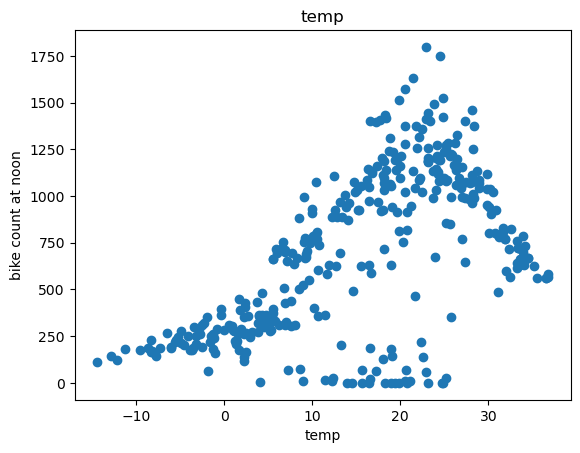

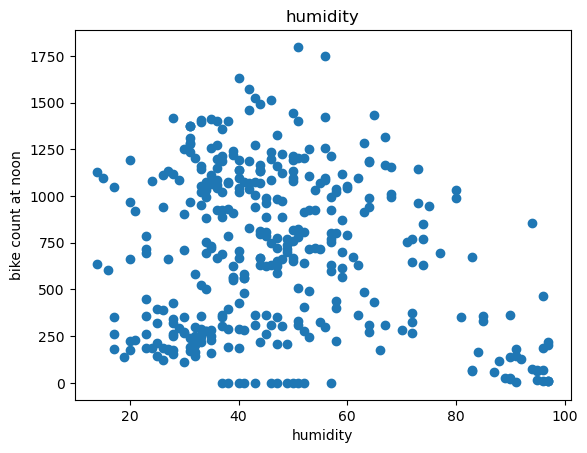

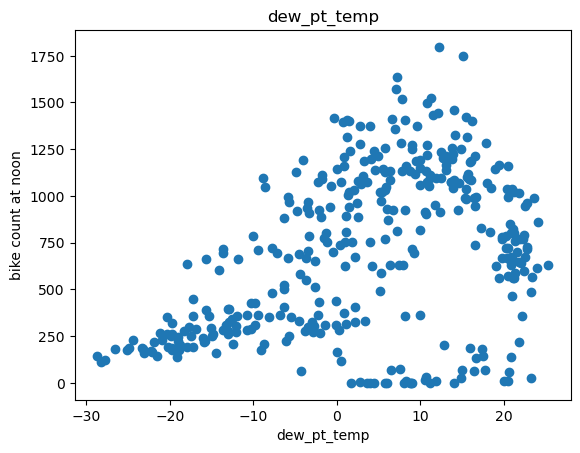

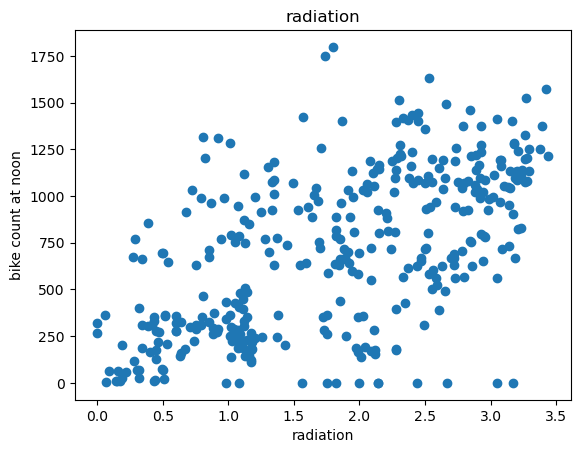

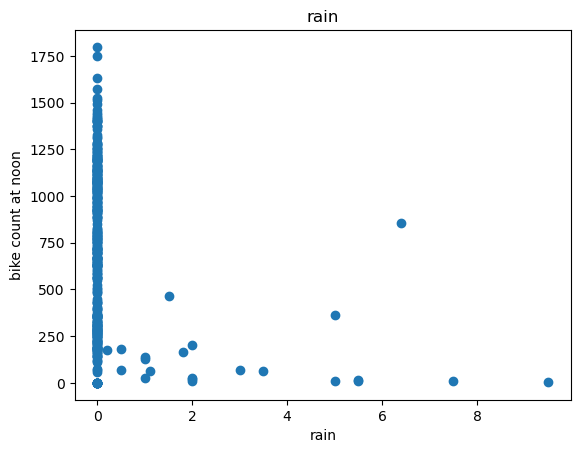

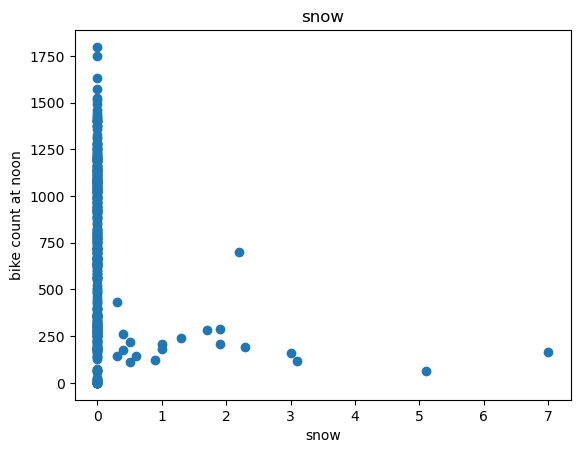

In [139]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("bike count at noon")
    plt.xlabel(label)
    plt.show()

In [ ]:
df = df.drop(["wind","visibility","functional"], axis =1)

In [141]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train, Valid and Test Dataset

In [143]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [163]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if not x_labels is None  :
        x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            x = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            x = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((x,y))

    return data, x, y

In [157]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])


In [158]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [159]:
temp_reg.score(x_test_temp, y_test_temp)

0.28864483504280725

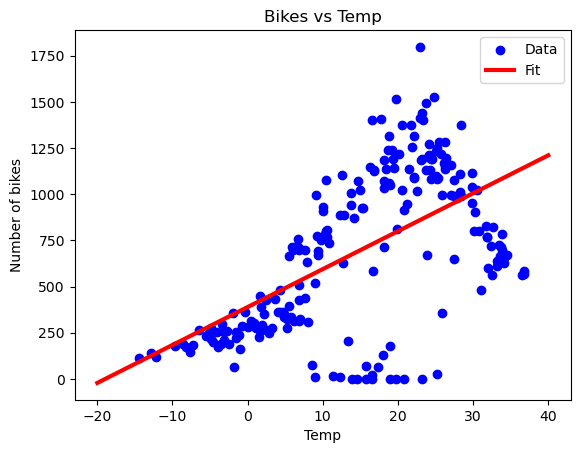

In [160]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()


# Multiple LRegression

In [161]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [164]:
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [165]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [166]:
all_reg.score(x_train_all, y_train_all)

0.49013609296683713

# Regression with Neural Network

In [183]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [178]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [179]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [181]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [182]:
# Fit the model with the reshaped data
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)


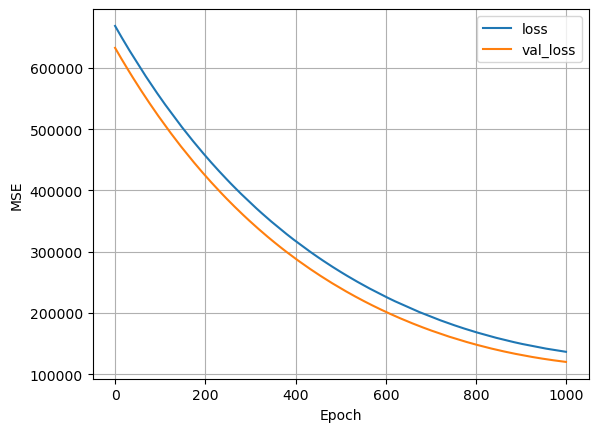

In [184]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


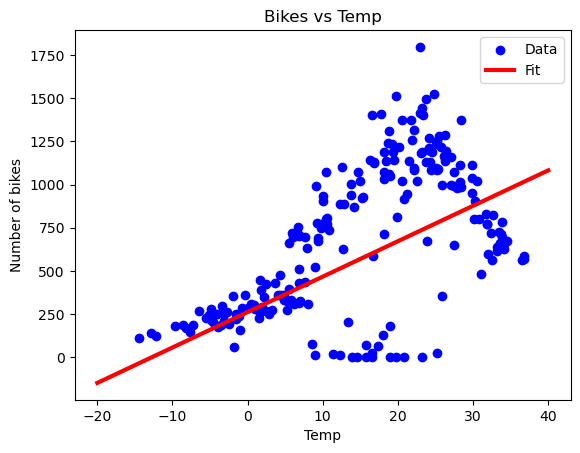

In [185]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Network

In [203]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [204]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data= (x_val_temp, y_val_temp),
    verbose=0, epochs=100
)

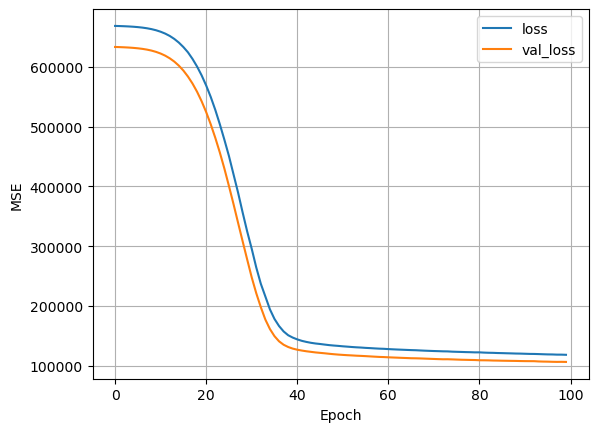

In [205]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


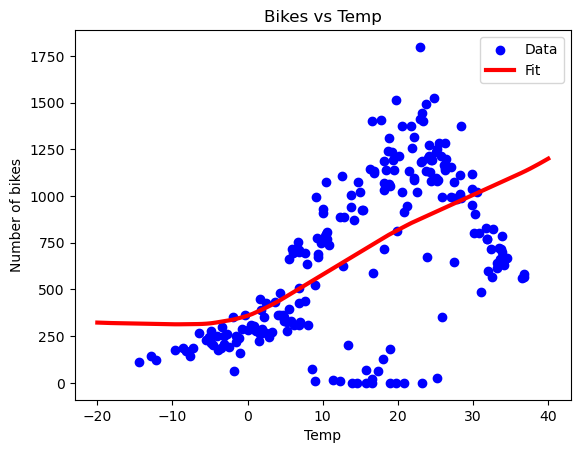

In [206]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [218]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

In [219]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [220]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data= (x_val_all, y_val_all),
    verbose=0, epochs=100
)

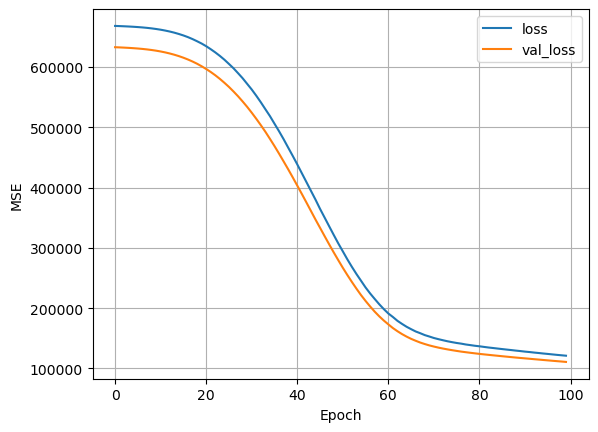

In [221]:
plot_loss(history)

In [222]:
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [223]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [224]:
MSE(y_pred_lr, y_test_all)

135066.19062309465

In [232]:
MSE(y_pred_nn, y_test_all)

140002.60517200423

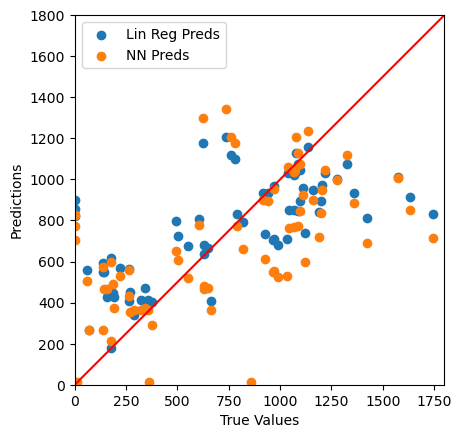

In [235]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')